# BUILDING A DEFUALT DETECTION MODEL

---



## Table of Contents
1. Problem Description (Brief Write Up)
2. Exploratory Data Analysis (EDA)
3. Data Pre-processing
4. Model Selection
5. Evaluation
6. Discussion and Possible Improvements

## 1. Problem Description

The goal of this project is to predict a binary target feature (default or not) valued 0 (= not default) or 1 (= default). This project will cover the entire data science pipeline, from data analysis to model evaluation. We will be trying several models to predict default status, and choosing the most appropriate one at the end. 

The data set we will be working on contains payment information of 30,000 credit card holders obtained from a bank in Taiwan, and each data sample is described by 23 feature attributes and the binary target feature (default or not).

The 23 explanatory attributes and their explanations (from the data provider) are as follows:

### X1 - X5: Indivual attributes of customer

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 

X2: Gender (1 = male; 2 = female). 

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

X4: Marital status (1 = married; 2 = single; 3 = others). 

X5: Age (year). 

### X6 - X11: Repayment history from April to Septemeber 2005
The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months, . . . 8 = payment delay for eight months; 9 = payment delay for nine months and above.


X6 = the repayment status in September, 2005

X7 = the repayment status in August, 2005

X8 = the repayment status in July, 2005

X9 = the repayment status in June, 2005

X10 = the repayment status in May, 2005

X11 = the repayment status in April, 2005. 

### X12 - X17: Amount of bill statement (NT dollar) from April to September 2005

X12 = amount of bill statement in September, 2005; 

X13 = amount of bill statement in August, 2005

. . .

X17 = amount of bill statement in April, 2005. 

### X18 - X23: Amount of previous payment (NT dollar)
X18 = amount paid in September, 2005

X19 = amount paid in August, 2005

. . .

X23 = amount paid in April, 2005. 


## EDA

In this section we will explore the data set, its shape and its features to get an idea of the data.

### Importing packages and the dataset

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np

In [4]:
url = 'https://raw.githubusercontent.com/reonho/bt2101disrudy/master/card.csv'
df = pd.read_csv(url,  header = 1, index_col = 0)
# Dataset is now stored in a Pandas Dataframe

In [5]:
#rename the target variable to "Y" for convenience
df["Y"] = df["default payment next month"] 
df = df.drop("default payment next month", axis = 1)
df0 = df #backup of df
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
size = df.shape
print("Data has {} Columns and {} Rows".format(size[1], size[0]))

Data has 24 Columns and 30000 Rows


In [7]:
#check for null values
df.isnull().any().sum() 

0

From the above analyses, we observe that:
1. The data indeed has 30000 rows and 24 columns
2. There are no null values

We will now explore the features more in depth.

### Exploring the features

**1) Exploring target attribute:**


defaults : 22.12 %
non defaults : 77.88000000000001 %


Text(0, 0.5, 'Frequency')

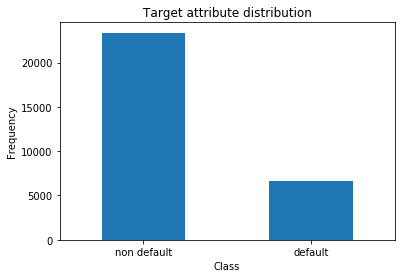

In [8]:
All = df.shape[0]
default = df[df['Y'] == 1]
nondefault = df[df['Y'] == 0]

x = len(default)/All
y = len(nondefault)/All

print('defaults :',x*100,'%')
print('non defaults :',y*100,'%')

# plotting target attribute against frequency
labels = ['non default','default']
classes = pd.value_counts(df['Y'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Target attribute distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

**2) Exploring categorical attributes**

Categorical attributes are:
- Sex
- Education
- Marriage

In [9]:
print(df["SEX"].value_counts().apply(lambda r: r/All*100))
print("--------------------------------------------------------")
print(df["EDUCATION"].value_counts().apply(lambda r: r/All*100))
print("--------------------------------------------------------")
print(df["MARRIAGE"].value_counts().apply(lambda r: r/All*100))

2    60.373333
1    39.626667
Name: SEX, dtype: float64
--------------------------------------------------------
2    46.766667
1    35.283333
3    16.390000
5     0.933333
4     0.410000
6     0.170000
0     0.046667
Name: EDUCATION, dtype: float64
--------------------------------------------------------
2    53.213333
1    45.530000
3     1.076667
0     0.180000
Name: MARRIAGE, dtype: float64


**Findings**

- Categorical variable SEX does not seem to have any missing/extra groups, and it is separated into Male = 1 and Female = 2
- Categorical variable MARRIAGE seems to have unknown group = 0, which could be assumed to be missing data, with other groups being Married = 1, Single = 2, Others = 3
- Categorical variable EDUCATION seems to have unknown group = 0,5,6, with other groups being graduate school = 1, university = 2, high school = 3, others = 4 

In [10]:
#proportion of target attribute (for reference)
print('Total target attributes:')
print('non defaults :',y*100,'%')
print('defaults :',x*100,'%')
print("--------------------------------------------------------")
#analysing default payment with Sex
sex_target = pd.crosstab(df["Y"], df["SEX"]).apply(lambda r: r/r.sum()*100).rename(columns = {1: "Male", 2: "Female"}, index = {0: "non defaults", 1: "defaults"})
print(sex_target)
print("--------------------------------------------------------")
#analysing default payment with education
education_target = pd.crosstab(df["Y"], df["EDUCATION"]).apply(lambda r: r/r.sum()*100).rename(index = {0: "non defaults", 1: "defaults"})
print(education_target)
print("--------------------------------------------------------")
#analysing default payment with marriage
marriage_target = pd.crosstab(df["Y"], df["MARRIAGE"]).apply(lambda r: r/r.sum()*100).rename(columns = {0: "unknown",1: "married", 2: "single", 3: "others"},index = {0: "non defaults", 1: "defaults"})
print(marriage_target)

Total target attributes:
non defaults : 77.88000000000001 %
defaults : 22.12 %
--------------------------------------------------------
SEX                Male     Female
Y                                 
non defaults  75.832773  79.223719
defaults      24.167227  20.776281
--------------------------------------------------------
EDUCATION         0          1          2          3          4          5  \
Y                                                                            
non defaults  100.0  80.765234  76.265146  74.842384  94.308943  93.571429   
defaults        0.0  19.234766  23.734854  25.157616   5.691057   6.428571   

EDUCATION             6  
Y                        
non defaults  84.313725  
defaults      15.686275  
--------------------------------------------------------
MARRIAGE        unknown    married     single     others
Y                                                       
non defaults  90.740741  76.528296  79.071661  73.993808
defaults       9.25925

**Conclusion**

From the analyses above we conclude that

1. The categorical data is noisy - EDUCATION and MARRIAGE contains unexplained/anomalous data.


**3) Analysis of Numerical Attributes**

The numerical attributes are:
   




In [11]:
#printing numerical attributes
pd.DataFrame(df.drop(['SEX', 'EDUCATION', 'MARRIAGE','Y'], axis = 1).columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6


In [90]:
df.drop(['SEX', 'EDUCATION', 'MARRIAGE','Y'], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,26245.0,0.284337,0.237875,0.0,0.081633,0.224490,0.408163,1.0
AGE,26245.0,0.368595,0.232422,0.0,0.184211,0.342105,0.526316,1.0
PAY_0,26245.0,0.372109,0.765730,0.0,0.000000,0.000000,0.000000,8.0
PAY_2,26245.0,0.337321,0.814878,0.0,0.000000,0.000000,0.000000,8.0
PAY_3,26245.0,0.324633,0.811491,0.0,0.000000,0.000000,0.000000,8.0
PAY_4,26245.0,0.278224,0.786314,0.0,0.000000,0.000000,0.000000,8.0
PAY_5,26245.0,0.238750,0.743923,0.0,0.000000,0.000000,0.000000,8.0
PAY_6,26245.0,0.243208,0.740345,0.0,0.000000,0.000000,0.000000,8.0
BILL_AMT1,26245.0,0.200168,0.189380,0.0,0.057590,0.122923,0.265297,1.0
BILL_AMT2,26245.0,0.254917,0.174586,0.0,0.123671,0.185749,0.308929,1.0


**Analysis of PAY_0 to PAY_6**

We observe that the minimum value of PAY_0 to PAY_6 is -2. The dataset's author has explained these factors (PAY_0 to PAY_6) as the number of months of payment delay, that is, 1= payment delay of one month; 2= payment delay of two months and so on. 

However, the presence of -2, -1 in these columns indicates that
1. There is anomalous data, OR 
2. The numbers do not strictly correspond to the number of months of payment delay. 

This means we must conduct some data transformation.

According to **(link)**, the numeric value in these attributes shows the past history of a credit card holder, where -2 means: No consumption of credit card, -1 means that holder paid the full balance, and 0 means the use of revolving credit.



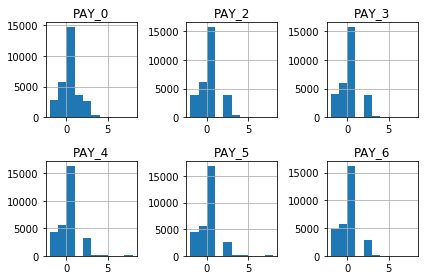

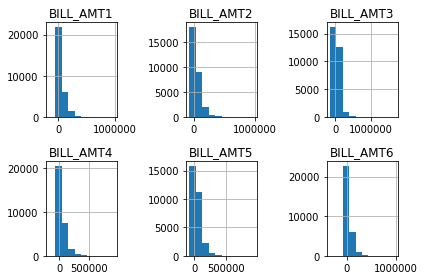

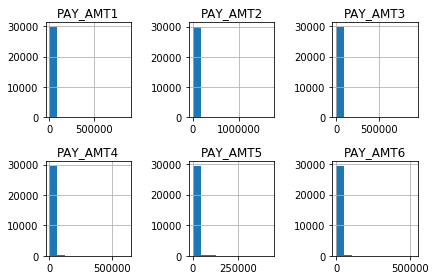

In [13]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

PAY = df[['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
BILLAMT = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
PAYAMT = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

draw_histograms(PAY, PAY.columns, 2, 3, 10)
draw_histograms(BILLAMT, BILLAMT.columns, 2, 3, 10)
draw_histograms(PAYAMT, PAYAMT.columns, 2, 3, 10)

We observe that the "repayment status" attributes are the most highly correlated with the target variable and we would expect them to be more significant in predicting credit default. In fact the later the status (pay_0 is later than pay_6), the more correlated it is.

Now that we have an idea of the features, we will move on to feature selection and data preparation.

## Data Preprocessing

It was previously mentioned that our data had a bit of noise, so we will clean up the data in this part. Additionally, we will conduct some feature selection.
1. Removing Noise - Inconsistencies
2. Dealing with negative values of PAY_0 to PAY_6
3. Outliers
4. One Hot Encoding
5. Train Test Split
6. Feature selection


### Removing Noise
First, we found in our data exploration that education has unknown groups 0, 5 and 6. These will be replaced with Education = Others, which has value 4

In [14]:
df['EDUCATION'].replace([0,5,6], 4, regex=True, inplace=True)
df["EDUCATION"].unique()

array([2, 1, 3, 4], dtype=int64)

Similarly, for Marriage

In [15]:
df['MARRIAGE'].replace([0], 3, regex=True, inplace=True)
df["MARRIAGE"].unique()

array([1, 2, 3], dtype=int64)

### Separating negative and positive values for PAY_0 to PAY_6

Second, we are going to extract the negative values of PAY_0 to PAY_6 as another categorical feature. This way, PAY_0 to PAY_6 can be thought of purely as the months of delay of payments.

The negative values will form a categorical variable. e.g. negative values of PAY_0 will form the categorical variable S_0.

In [16]:
for i in range(0,7):
    try:
        df["S_" + str(i)] = [x  if x < 1 else 1 for x in df["PAY_" + str(i)]]
    except:
        pass

In [94]:
print('Dummy variables for negative values')
df[["S_0", "S_2", "S_3", "S_4", "S_5", "S_6"]]

Dummy variables for negative values


,S_0,S_2,S_3,S_4,S_5,S_6
ID,,,,,,
1,1,1,-1,-1,-2,-2
2,-1,1,0,0,0,1
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,-1,0,-1,0,0,0
...,...,...,...,...,...,...
29995,1,1,1,1,1,1
29996,0,0,0,0,0,0
29997,-1,-1,-1,-1,0,0


In [18]:
#attributes representing positive values
for col in ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]:
    df[col].replace([0,-1,-2], 0, regex=True, inplace=True)

### Outliers
Next, we would like to remove outliers from the continuous variables. Assuming that all the data points are normally distributed, we will consider a point an outlier if it falls outside the 99% interval of a distribution. (Critical value = 2.58) 

In [19]:
from scipy import stats
#we are only concerned with the ordinal data
o = pd.DataFrame(df.drop(['Y','EDUCATION', 'MARRIAGE', "SEX","S_0", "S_2", "S_3", "S_4", "S_5", "S_6","PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"], axis=1))
#rows where the absolute z score of all columns are less than 2.58 (critical value)
rows = (np.abs(stats.zscore(o)) < 2.58).all(axis=1)
df = df[rows]
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,S_0,S_2,S_3,S_4,S_5,S_6
count,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,...,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000,26245.000000
mean,149324.899981,1.608954,1.852734,1.564717,35.006592,0.372109,0.337321,0.324633,0.278224,0.238750,...,2787.425071,2778.830673,2822.285007,0.230177,-0.133587,-0.300438,-0.327300,-0.364412,-0.395999,-0.428158
std,116558.616530,0.487994,0.738572,0.521936,8.832028,0.765730,0.814878,0.811491,0.786314,0.743923,...,4835.081906,4751.263287,5271.198100,0.420954,0.879876,0.883472,0.895264,0.886115,0.877789,0.900723
min,10000.000000,1.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,150.000000,82.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,120000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1200.000000,1218.000000,1143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,210000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3118.000000,3140.000000,3069.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,500000.000000,2.000000,4.000000,3.000000,59.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,45171.000000,44197.000000,51000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Scaling
The models used subsequently may have difficulty converging before the maximum number of iterations allowed
is reached if the data is not normalized. Additionaly, Multi-layer Perceptron is sensitive to feature scaling, so we will use StandardScaler for standardization. We only want to scale the numerical factors.

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols = df.drop(['Y','EDUCATION', 'MARRIAGE', "SEX","S_0", "S_2", "S_3", "S_4", "S_5", "S_6","PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"], axis =1)
df1 = df.copy()
df1[cols.columns] = scaler.fit_transform(cols)
df = df1

In [21]:
df1.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,S_0,S_2,S_3,S_4,S_5,S_6
ID,,,,,,,,,,,,,,,,,,,,,
1,0.020408,2,2,1,0.078947,2,2,0,0,0,...,0.000000,0.000000,0.000000,1,1,1,-1,-1,-2,-2
2,0.224490,2,2,2,0.131579,0,2,0,0,0,...,0.022138,0.000000,0.039216,1,-1,1,0,0,0,1
3,0.163265,2,2,2,0.342105,0,0,0,0,0,...,0.022138,0.022626,0.098039,0,0,0,0,0,0,0
4,0.081633,2,2,1,0.421053,0,0,0,0,0,...,0.024352,0.024187,0.019608,0,0,0,0,0,0,0
5,0.081633,1,2,1,0.947368,0,0,0,0,0,...,0.199243,0.015589,0.013314,0,-1,0,-1,0,0,0


### One-Hot Encoding for Categorical attributes

In some models, categorical variables which are encoded numerically will be erroneously treated as ordinal data. To understand why this is a problem, consider the "Education" column for our dataset.

A logistic regression model, for example, will assume that the difference in odds of default between education = 1 and education = 2 is the same as the difference between education = 2 and 3. This is wrong because the difference in odds between a graduate degree and university (1 and 2) is likely to be different from that between univeristy education and high school education (2 and 3).

One hot encoding will allow our models to treat these columns explicitly as categorical features.

The following categorical columns will be one-hot encoded

1. EDUCATION
2. MARRIAGE
3. S0 - S6


In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
onenc = OneHotEncoder(categories='auto')

In [24]:
#one hot encoding for EDUCATION and MARRIAGE
onehot = pd.DataFrame(onenc.fit_transform(df[['EDUCATION', 'MARRIAGE']]).toarray())
onehot.columns= names = ["GRAD","UNI","HS","OTHER-EDU","MARRIED","SINGLE","OTHER_MS"]
#drop one of each category to prevent dummy variable trap
onehot = onehot.drop(["OTHER-EDU", "OTHER_MS"], axis = 1)
onehot.head()

,GRAD,UNI,HS,MARRIED,SINGLE
0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0


In [25]:
#one hot encoding for S_0 to S_6
onehot_PAY = pd.DataFrame(onenc.fit_transform(df[['S_0', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6']]).toarray())
onehot_PAY.columns= onenc.fit(df[["S_0", "S_2", "S_3", "S_4", "S_5", "S_6"]]).get_feature_names()
#drop one of each category to prevent dummy variable trap
#onehot = onehot.drop(["OTHER-EDU", "OTHER_MS"], axis = 1)
names = []
for X in range(0,7):
    if X == 1:
        continue
    names.append("PAY_"+str(X)+"_No_Transactions")
    names.append("PAY_"+str(X)+"_Pay_Duly")
    names.append("PAY_"+str(X)+"_Revolving_Credit")
    try:
        onehot_PAY = onehot_PAY.drop("x" + str(X) +"_1", axis =1)
    except:
        onehot_PAY = onehot_PAY.drop("x1_1", axis =1)
onehot_PAY.columns = names
onehot_PAY.head()

,PAY_0_No_Transactions,PAY_0_Pay_Duly,PAY_0_Revolving_Credit,PAY_2_No_Transactions,PAY_2_Pay_Duly,PAY_2_Revolving_Credit,PAY_3_No_Transactions,PAY_3_Pay_Duly,PAY_3_Revolving_Credit,PAY_4_No_Transactions,PAY_4_Pay_Duly,PAY_4_Revolving_Credit,PAY_5_No_Transactions,PAY_5_Pay_Duly,PAY_5_Revolving_Credit,PAY_6_No_Transactions,PAY_6_Pay_Duly,PAY_6_Revolving_Credit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [97]:
df1 = df.drop(['EDUCATION', 'MARRIAGE','S_0', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6'], axis = 1)
df1 = pd.concat([df1.reset_index(drop=True), onehot], axis=1)
df1 = pd.concat([df1.reset_index(drop=True), onehot_PAY], axis=1)
df1.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y', 'GRAD', 'UNI', 'HS', 'MARRIED',
       'SINGLE', 'PAY_0_No_Transactions', 'PAY_0_Pay_Duly',
       'PAY_0_Revolving_Credit', 'PAY_2_No_Transactions', 'PAY_2_Pay_Duly',
       'PAY_2_Revolving_Credit', 'PAY_3_No_Transactions', 'PAY_3_Pay_Duly',
       'PAY_3_Revolving_Credit', 'PAY_4_No_Transactions', 'PAY_4_Pay_Duly',
       'PAY_4_Revolving_Credit', 'PAY_5_No_Transactions', 'PAY_5_Pay_Duly',
       'PAY_5_Revolving_Credit', 'PAY_6_No_Transactions', 'PAY_6_Pay_Duly',
       'PAY_6_Revolving_Credit'],
      dtype='object')

In [27]:
#check for perfect collinearity
corr = df1.corr()
for i in range(len(corr)):
    corr.iloc[i,i] = 0
#corr[corr == 1] = 0
corr[corr.eq(1).any(1)]

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_3_Revolving_Credit,PAY_4_No_Transactions,PAY_4_Pay_Duly,PAY_4_Revolving_Credit,PAY_5_No_Transactions,PAY_5_Pay_Duly,PAY_5_Revolving_Credit,PAY_6_No_Transactions,PAY_6_Pay_Duly,PAY_6_Revolving_Credit


In [28]:
size = df1.shape
print("Data has {} Columns and {} Rows".format(size[1], size[0]))

Data has 45 Columns and 26245 Rows


### Train Test Split

Before we conduct feature selection and model selection, we split the data using a train test split according to the project description.

In [29]:
from sklearn.metrics import *
from sklearn.model_selection import *

In [30]:
#using holdout sampling for train test split
ft = df1.drop("Y", axis = 1)
target = df1["Y"]
X_train,X_test,y_train,y_test = train_test_split(ft,target,test_size=0.33333)
#make the results reproducible (according to instructions)
np.random.seed(123) 

### Filter method for feature selection
The filter method for feature selection entails selecting relevant attributes before moving on to learning phase.
We will utitlise univariate feature selection to reduce the features to the fewer more significant attributes. 

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest( score_func = chi2, k=10)
selector.fit(X_train, y_train)
np.set_printoptions(precision=10)
chi2data = pd.DataFrame(selector.scores_)
chi2data["pval"] = 1 - stats.chi2.cdf(chi2data, 43)
chi2data.index = X_train.columns

print("Significant values are:")
print(chi2data[chi2data["pval"] < 0.05])

cols = chi2data[chi2data["pval"] < 0.05].index
X_train_filter = X_train[cols]
X_test_filter = X_test[cols]

Significant values are:
                                  0          pval
LIMIT_BAL                 81.747784  3.335170e-04
PAY_0                   4215.816943  0.000000e+00
PAY_2                   3730.186349  0.000000e+00
PAY_3                   3017.725262  0.000000e+00
PAY_4                   3020.555618  0.000000e+00
PAY_5                   2812.887854  0.000000e+00
PAY_6                   2575.321192  0.000000e+00
PAY_0_No_Transactions     63.305610  2.349730e-02
PAY_0_Revolving_Credit   454.630595  0.000000e+00
PAY_2_Pay_Duly            76.591060  1.225866e-03
PAY_2_Revolving_Credit   241.568619  0.000000e+00
PAY_3_Pay_Duly            88.958886  4.790331e-05
PAY_3_Revolving_Credit   140.257620  3.064993e-12
PAY_4_Pay_Duly            82.933933  2.446182e-04
PAY_4_Revolving_Credit    98.729838  2.851222e-06
PAY_5_Pay_Duly            67.720209  9.456393e-03
PAY_5_Revolving_Credit    70.202609  5.486203e-03
PAY_6_Revolving_Credit    73.167377  2.782902e-03


## Model Selection

In this part, we will fit machine learning models learnt in BT2101 to this classification problem, and pick the model that can produce the best results.

We will be attempting to fit the following models:


- Decision Tree 
- Logistic Regression
- Support Vector Machine
- Neural Network

To make things easier, we define a get_roc function that will plot an ROC curve for all the models we evaluate, and a confusion matrix function.


In [32]:
def get_roc(model, y_test, X_test, name):
    try:
        fpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[0]
        tpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[1]
        thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])[2]
    except:
        fpr = roc_curve(y_test,model.predict(X_test))[0]
        tpr = roc_curve(y_test,model.predict(X_test))[1]
        thresholds = roc_curve(y_test,model.predict(X_test))[2]
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + name)
    plt.plot(fpr,tpr,label='ROC curve (AUC = %0.2f)' % (auc(fpr, tpr)))
    plt.legend(loc="lower right")
    
    #find- best threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal Threshold: " + str(optimal_threshold))
    
    plt.show()
    
    return auc(fpr, tpr)

In [33]:
def confusion(y_test, predictions, name):
    conf = pd.crosstab(y_test,predictions, rownames=['Actual'], colnames=['Predicted'])
    print("Of " + str(conf[0][1] + conf[1][1]) + " Defaulters, the " + name + " identified " + str(conf[1][1])) 
    return conf

### Evaluation 
We will select the model based on the model evaluation. The key metrics we will compute are:

1. Accuracy
2. Recall
3. AUROC

Because of the nature of a default detection problem, we would like to prioritise **recall** for defaults. 
This means we will place more importance in correctly identifying a defaulter than avoiding misclassifying a non-defaulter. (Assumming that the bank loses more money when lending to a defaulter than not lending to a non-defaulter)

However, simply predicting every data point as a defaulter will give us 100% recall. We have to also consider accuracy and AUROC to get a better idea of how our model performs.


In [34]:
evaluation = pd.DataFrame(columns=['Model', 'Recall-1', 'AUROC'])

###  Decision Trees

#### Theory:
The decision tree algorithm aims to recursively split the data points in the training set until the data points are completely separated or well separated. At each iteration, the tree splits the datasets by the feature(s) that give the maximum reduction in heterogeneity, which is calculated by a heterogeneity index.

Below is a binary decision tree that has been split for a few iterations.

![image.png](https://elf11.github.io/images/decisionTree.png)

Since the target for this project is binary (fraud = yes or no) we will be building a binary decision tree, using the the GINI Index as the Heterogeneity index. The GINI is given by:

![image.png](https://miro.medium.com/max/664/1*otdoiyIwxJI-UV0ukkyutw.png)

The GINI index measures how heterogenous a single node is (0 being completely homogenous and 1 being heterogenous). For each possible split, we will calculate the *weighted sum* of the GINI indices of the child nodes, and choose the split that results in the maximum information gain. i.e. reduction in the weighted sum of the GINI Index.

#### Training
We will now construct a simple decision tree using the GINI index.

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
print(classification_report(y_train, tree.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13475
           1       1.00      1.00      1.00      4021

    accuracy                           1.00     17496
   macro avg       1.00      1.00      1.00     17496
weighted avg       1.00      1.00      1.00     17496



The training set accuracy is 1, which means the datapoints are completely separated by the decision tree. We evaluate on the test set below.

In [38]:
confusion(y_test, tree.predict(X_test), "Decision Tree (GINI)")

Of 2020 Defaulters, the Decision Tree (GINI) identified 828


Predicted,0,1
Actual,,
0,5415,1314
1,1192,828


Optimal Threshold: 0.6666666666666666


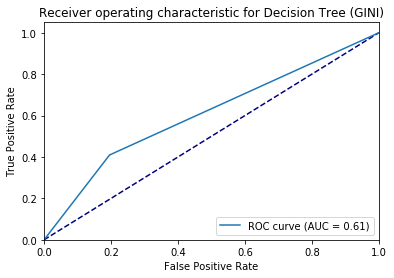

In [39]:
auroc = get_roc(tree, y_test, X_test, "Decision Tree (GINI)")

In [40]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      6729
           1       0.39      0.41      0.40      2020

    accuracy                           0.71      8749
   macro avg       0.60      0.61      0.60      8749
weighted avg       0.72      0.71      0.72      8749



In [41]:
evaluation.loc[0] = (["Decision Tree" , 
                      classification_report(y_test, tree.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

### Random Forest Classifier

#### Theory
Random Forest is an ensemble method for the decision tree algorithm. It works by randomly choosing different features and data points to train multiple trees (that is, to form a forest) - and the resulting prediction is decided by the votes from all the trees. 

Decision Trees are prone to overfitting on the training data, which reduces the performance on the test set. Random Forest mitigates this by training multiple trees. Random Forest is a form of bagging ensemble where the trees are trained concurrently. 

#### Training
To keep things consistent, our Random Forest classifier will also use the GINI Coefficient.



In [42]:
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(n_estimators=300)

In [43]:
randf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
print(classification_report(y_train, randf.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13475
           1       1.00      1.00      1.00      4021

    accuracy                           1.00     17496
   macro avg       1.00      1.00      1.00     17496
weighted avg       1.00      1.00      1.00     17496



The training set has also been 100% correctly classified by the random forest model. Evaluating with the test set:

In [45]:
confusion(y_test, randf.predict(X_test), "Decision Tree (Random Forest)")

Of 2020 Defaulters, the Decision Tree (Random Forest) identified 749


Predicted,0,1
Actual,,
0,6310,419
1,1271,749


Optimal Threshold: 0.26


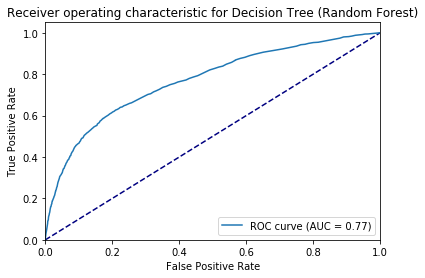

In [46]:
auroc = get_roc(randf, y_test, X_test, "Decision Tree (Random Forest)")

In [47]:
print(classification_report(y_test, randf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      6729
           1       0.64      0.37      0.47      2020

    accuracy                           0.81      8749
   macro avg       0.74      0.65      0.68      8749
weighted avg       0.79      0.81      0.79      8749



In [48]:
evaluation.loc[1] = (["Random Forest" , 
                      classification_report(y_test, randf.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

The random forest ensemble performs much better than the decision tree alone. The accuracy and AUROC are both superior to the decision tree alone.

### Gradient Boosted Trees Classifier

#### Theory
In this part we train a gradient boosted trees classifier using xgBoost. xgBoost is short for "Extreme Gradient Boosting". It is a boosting ensemble method for decision trees, which means that the trees are trained consecutively, where each new tree added is trained to correct the error from the previous tree.

xgBoost uses the gradient descent algorithm that we learnt in BT2101 at each iteration to maximise the reduction in the error term. (More details? math?)
 
#### Training
For consistency our xgBoost ensemble will use n_estimators = 300 as we have done for the random forest ensemble.

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
xgb = GradientBoostingClassifier(n_estimators=300, max_depth = 4)
xgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [50]:
print(classification_report(y_train, xgb.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     13475
           1       0.79      0.46      0.58      4021

    accuracy                           0.85     17496
   macro avg       0.82      0.71      0.74     17496
weighted avg       0.84      0.85      0.83     17496



We observe that the xgBoost ensemble did not fully separate the data in the training set. (The default maximum depth is 3, so that might be a factor). Evaluating on the test set,

In [51]:
confusion(y_test, xgb.predict(X_test), "Decision Tree (Gradient Boosted Trees)")

Of 2020 Defaulters, the Decision Tree (Gradient Boosted Trees) identified 750


Predicted,0,1
Actual,,
0,6339,390
1,1270,750


Optimal Threshold: 0.26114231320864134


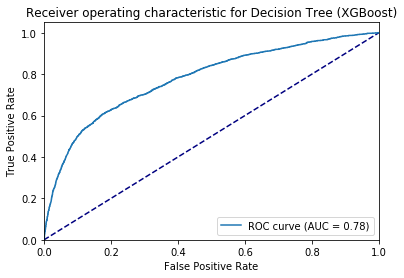

In [52]:
auroc = get_roc(xgb, y_test, X_test, "Decision Tree (XGBoost)")

In [53]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      6729
           1       0.66      0.37      0.47      2020

    accuracy                           0.81      8749
   macro avg       0.75      0.66      0.68      8749
weighted avg       0.79      0.81      0.79      8749



In [54]:
evaluation.loc[2] = (["Gradient Boosted" , 
                      classification_report(y_test, xgb.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

From the accuracy and AUROC, we observe that the XGBoost performs similarly to the random forest ensemble. It has a slight bump in AUROC at 0.76, but the accuracy is the same.

In [55]:
evaluation

,Model,Recall-1,AUROC
0,Decision Tree,0.409901,0.606997
1,Random Forest,0.370792,0.768455
2,Gradient Boosted,0.371287,0.778407


### Logistic Regression

#### Theory
Logistic regression is a regression technnique used to predict binary target variables. It works on the same principles as a linear regression model. 

Our binary target (default vs non-default) can be expressed in terms of odds of defaulting, which is the ratio of the probability of default and probability of non-default. 

In the logistic regression model, we log the odds (log-odds) and equate it to a weighted sum of regressors.

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/4a5e86f014eb1f0744e280eb0d68485cb8c0a6c3)

We then find weights for the regressors that best fits the data. Since the binary target (default or not) follows a bernoulli distribution, each data point has the following probability distribution function:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/614e0c64d59f0ff2e926deafcb2de6e502394fac)

We would like to update p for each data point such that the log product (joint probability) of the above function for all data points is maximised. In other words, we are maximising the log-likelihood function.

The logistic regression equation produces a "squashed" curve like the one below. We then pick a cutoff value for the y axis to classify a data point as 0 (non-default) or 1 (default).

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png)


#### Training
We will adopt a top-down approach for training our logistic regression model, i.e. include all regressors first and then remove the most insignificant ones at each iteration to achieve the best fit.

In [56]:
import statsmodels.api as sm

In [57]:
glm = sm.Logit(y_train,X_train).fit()
glm.summary()

Optimization terminated successfully.
         Current function value: 0.445436
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                17496
Model:                          Logit   Df Residuals:                    17452
Method:                           MLE   Df Model:                           43
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.1737
Time:                        19:35:44   Log-Likelihood:                -7793.4
converged:                       True   LL-Null:                       -9431.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
LIMIT_BAL                 -0.8354      0.114     -7.302      0.000      -1.060      -0.611
SEX                       -0.1196      0.041     -2.920      0.004      -0.200      -0.039
AGE                        0.0615      0.100      0.614      0.539      -0.135       0.258
PAY_0                      0.6546      0.059     11.081      0.000       0.539       0.770
PAY_2                     -0.5622      0.098     -5.715      0.000      -0.755      -0.369
PAY_3                     -0.1059      0.113     -0.941      0.347      -0.327       0.115
PAY_4                     -0.2041      0.159     -1.287      0.198      -0.515       0.107
PAY_5                     -0.0925      0.178     -0.521      0.603      -0.441       0.256
PAY_6                      0.3289      0.147      2.244      0.025       0.042       0.616
BILL_AMT1                 -1.0372      0.528     -1.964      0.049      -2.072      -0.002
BILL_AMT2                  0.6000      0.765      0.785      0.433      -0.899       2.099
BILL_AMT3                  1.5425      0.732      2.107      0.035       0.107       2.978
BILL_AMT4                  0.2846      0.715      0.398      0.690      -1.116       1.686
BILL_AMT5                 -1.9241      0.913     -2.107      0.035      -3.714      -0.134
BILL_AMT6                  1.3621      0.839      1.623      0.105      -0.283       3.007
PAY_AMT1                  -1.1622      0.306     -3.794      0.000      -1.763      -0.562
PAY_AMT2                  -2.0159      0.390     -5.172      0.000      -2.780      -1.252
PAY_AMT3                  -0.5874      0.310     -1.898      0.058      -1.194       0.019
PAY_AMT4                  -0.0638      0.281     -0.227      0.820      -0.614       0.487
PAY_AMT5                  -1.0410      0.291     -3.576      0.000      -1.612      -0.470
PAY_AMT6                  -0.3858      0.256     -1.507      0.132      -0.887       0.116
GRAD                       1.3893      0.230      6.030      0.000       0.938       1.841
UNI                        1.3690      0.229      5.975      0.000       0.920       1.818
HS                         1.3654      0.233      5.863      0.000       0.909       1.822
MARRIED                    0.0176      0.158      0.111      0.911      -0.292       0.328
SINGLE                    -0.0968      0.159     -0.609      0.543      -0.408       0.215
PAY_0_No_Transactions      0.0316      0.124      0.255      0.799      -0.211       0.274
PAY_0_Pay_Duly             0.2120      0.122      1.734      0.083      -0.028       0.452
PAY_0_Revolving_Credit    -0.6866      0.137     -5.022      0.000      -0.955      -0.419
PAY_2_No_Transactions     -1.4519      0.236     -6.151      0.000      -1.914      -0.989
PAY_2_Pay_Duly            -1.3960      0.225     -6.201      0.000      -1.837      -0.955
PAY_2_Revolving_Credit    -0.9936      0.230     -4.318      0.000      -1.445      -0.543
PAY_3_No_Transactions     -0.5672      0.275     -2.059 

In [58]:
print(classification_report(y_train,list(glm.predict(X_train)>0.5)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     13475
           1       0.67      0.35      0.46      4021

    accuracy                           0.81     17496
   macro avg       0.75      0.65      0.67     17496
weighted avg       0.79      0.81      0.79     17496



In [59]:
print(classification_report(y_test,list(glm.predict(X_test)>0.5)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6729
           1       0.69      0.35      0.47      2020

    accuracy                           0.81      8749
   macro avg       0.76      0.65      0.68      8749
weighted avg       0.80      0.81      0.79      8749



The logisitc model with all features performs quite well on both the train and test set with an accuracy of about 0.8. We will now try removing all the insignificant features to see how that affects the model performance.

In [60]:
#remove all insignificant attributes
sig = glm.pvalues[glm.pvalues < 0.05]
glm_2 = sm.Logit(y_train,X_train[sig.index]).fit()
glm_2.summary()

Optimization terminated successfully.
         Current function value: 0.446914
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                17496
Model:                          Logit   Df Residuals:                    17472
Method:                           MLE   Df Model:                           23
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.1709
Time:                        19:35:44   Log-Likelihood:                -7819.2
converged:                       True   LL-Null:                       -9431.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
LIMIT_BAL                 -0.7989      0.111     -7.183      0.000      -1.017      -0.581
SEX                       -0.1204      0.040     -2.986      0.003      -0.199      -0.041
PAY_0                      0.5793      0.037     15.471      0.000       0.506       0.653
PAY_2                     -0.6376      0.077     -8.284      0.000      -0.788      -0.487
PAY_6                      0.2012      0.030      6.656      0.000       0.142       0.260
BILL_AMT1                 -0.8123      0.359     -2.261      0.024      -1.516      -0.108
BILL_AMT3                  2.2505      0.535      4.206      0.000       1.202       3.299
BILL_AMT5                 -0.9943      0.358     -2.779      0.005      -1.696      -0.293
PAY_AMT1                  -1.3333      0.287     -4.642      0.000      -1.896      -0.770
PAY_AMT2                  -2.3238      0.373     -6.232      0.000      -3.055      -1.593
PAY_AMT5                  -0.9218      0.252     -3.658      0.000      -1.416      -0.428
GRAD                       1.2429      0.179      6.961      0.000       0.893       1.593
UNI                        1.2478      0.177      7.052      0.000       0.901       1.595
HS                         1.2675      0.181      7.014      0.000       0.913       1.622
PAY_0_Revolving_Credit    -0.8716      0.092     -9.431      0.000      -1.053      -0.690
PAY_2_No_Transactions     -1.6757      0.200     -8.387      0.000      -2.067      -1.284
PAY_2_Pay_Duly            -1.4967      0.179     -8.379      0.000      -1.847      -1.147
PAY_2_Revolving_Credit    -1.0909      0.182     -6.007      0.000      -1.447      -0.735
PAY_3_No_Transactions     -0.3503      0.159     -2.199      0.028      -0.663      -0.038
PAY_3_Pay_Duly            -0.3319      0.111     -3.003      0.003      -0.548      -0.115
PAY_3_Revolving_Credit    -0.3494      0.081     -4.332      0.000      -0.507      -0.191
PAY_4_No_Transactions     -0.2852      0.130     -2.193      0.028      -0.540      -0.030
PAY_4_Pay_Duly            -0.5573      0.103     -5.433      0.000      -0.758      -0.356
PAY_4_Revolving_Credit    -0.4761      0.075     -6.332      0.000      -0.623      -0.329
==========================================================================================
"""

In [61]:
print(classification_report(y_train,list(glm_2.predict(X_train[sig.index])>0.5)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     13475
           1       0.66      0.36      0.46      4021

    accuracy                           0.81     17496
   macro avg       0.75      0.65      0.67     17496
weighted avg       0.79      0.81      0.79     17496



In [62]:
print(classification_report(y_test,list(glm_2.predict(X_test[sig.index])>0.5)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6729
           1       0.68      0.35      0.47      2020

    accuracy                           0.81      8749
   macro avg       0.75      0.65      0.68      8749
weighted avg       0.80      0.81      0.79      8749



Since there is not much change to the model performance on both the train and test set when we reduce the features, we will use the reduced logistic regression model from this point onwards (Principle of Parsimony). 

We now Calculate the AUROC for the train set.

Optimal Threshold: 0.22554888390620112


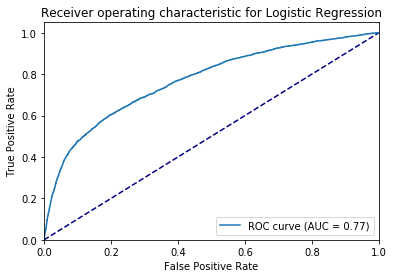

0.7698058845975142

In [63]:
get_roc(glm_2, y_train, X_train[sig.index], "Logistic Regression")

Since the optimal cut off was found to be 0.2697615225249289 using the training data, we will use that as our cut off for our evaluation of the test set.

In [64]:
print(classification_report(y_test,list(glm_2.predict(X_test[sig.index])>0.2697615225249289)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      6729
           1       0.54      0.55      0.54      2020

    accuracy                           0.79      8749
   macro avg       0.70      0.70      0.70      8749
weighted avg       0.79      0.79      0.79      8749



Unfortunately, the training accuracy has gone down when we used the optimal cutoff. However, accuracy may be misleading in a dataset like ours where most of the targets are non-defaults. 

The recall here is more important - detecting defaulters is more useful than detecting non-defaulters. With a higher recall, our model with lower cutoff is able to correctly catch more defaulters.


Calculate the confusion matrices for both cut offs to better compare their performance.

In [65]:
confusion(y_test,glm_2.predict(X_test[sig.index])>0.2697615225249289, "Logistic Regression")

Of 2020 Defaulters, the Logistic Regression identified 1104


Predicted,False,True
Actual,,
0,5790,939
1,916,1104


In [66]:
confusion(y_test,glm_2.predict(X_test[sig.index])>0.50, "Logistic Regression")

Of 2020 Defaulters, the Logistic Regression identified 716


Predicted,False,True
Actual,,
0,6391,338
1,1304,716


It is evident that the lower cutoff is better able to detect defualts.

Optimal Threshold: 0.21841387811546378


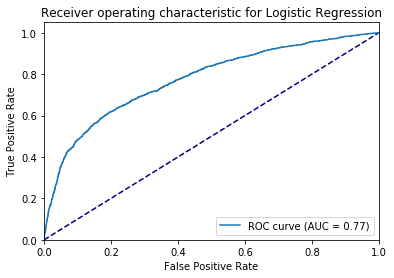

In [67]:
auroc = get_roc(glm_2, y_test, X_test[sig.index], "Logistic Regression")

In [68]:
evaluation.loc[3] = ["Logistic Regression" , classification_report(y_test,list(glm_2.predict(X_test[sig.index])>0.2697615225249289), output_dict = True)["1"]["recall"],auroc]

### Support Vector Machine
#### Theory
Support vector machines attempt to find an optimal hyperplane that is able to separate the two classes in n-dimensional space. This is done by finding the hyperplane that maximises the distance between itself and support vectors (data points that lie closest to the decision boundary).

SVM is computationally expensive for a dataset with a lot of features. Therefore, it is neccessary at this stage to do some data reduction.

#### PCA
We would like to reduce the dimensionality of our dataset before training an SVM on it. This can be done through Principle Component Analysis (PCA). The idea would be to reduce the number of features without loss of information.

#### 2 Component PCA
First, we will visualize the information retained after performing a 2 component pca.

In [69]:
#perform pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents =  pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [70]:
#amount of information each principal component holds after projecting the data to a lower dimensional subspace.
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.2966725486 0.1736524263]


This shows that the information of principal component 1 retained is 28.4% and principal component 2 retained is 17.8%, both of which is quite low

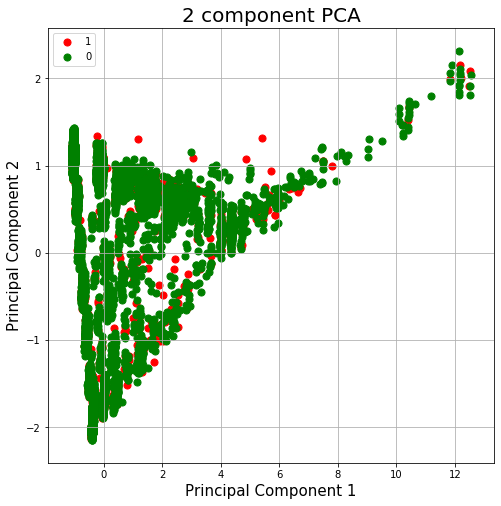

In [71]:
#visualizing pca
pca_visualize_df = pd.concat([principalDf, y_train], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pca_visualize_df['Y'] == target
    ax.scatter(pca_visualize_df.loc[indicesToKeep, 'principal component 1']
               , pca_visualize_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

As we can see, there is no clear linear separation for the target attributes for 2 pca components, justifying the above percentages. Nonetherless, we will continue to use PCA by finding the  optimmum number of PC components which retains 90% of information

### Perform PCA to retain 90% of information
perform PCA to reduce components so we can run SVM model

In [72]:
#setting pca threshold to 90%
pca = PCA(0.9)

In [73]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [74]:
#get number of components after pca
print('No. of components before pca: {}'.format(len(X_train.columns)))
print('No. of components after pca: {}'.format(pca.n_components_))

No. of components before pca: 44
No. of components after pca: 13


As we can see, the number of components is reduced from 26 components to 13 components

In [75]:
#perform pca on training and test attributes
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### Apply SVM model
Next, we will used the reduced attributes train set to train our SVM model

First, we train our SVM model without parameter tuning
nor pca reduction

In [76]:
from sklearn import svm
#train svm model without standardization and no parameter tuning
clf_original = svm.SVC(kernel = 'rbf', probability = True, gamma = 'scale')
clf_original.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Optimal Threshold: 0.1660749149902864


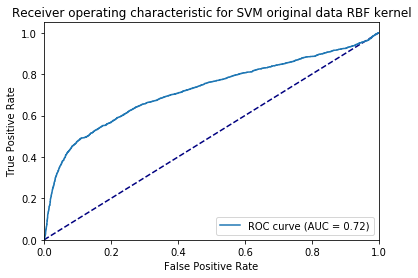

0.7220704605012441

In [77]:
#plot roc for svm
get_roc(clf_original, y_test, X_test, "SVM original data RBF kernel")

In [78]:
#confusion matrix
confusion(y_test,clf_original.predict(X_test), "SVM original data RBF kernel")

Of 2020 Defaulters, the SVM original data RBF kernel identified 733


Predicted,0,1
Actual,,
0,6391,338
1,1287,733


In [79]:
print(classification_report(y_test, clf_original.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6729
           1       0.68      0.36      0.47      2020

    accuracy                           0.81      8749
   macro avg       0.76      0.66      0.68      8749
weighted avg       0.80      0.81      0.79      8749



Evidently, SVM model fit with no tuning or feature reduction with RBF kernal shows low performance. Now, we will fit SVM model with reduced standardized features and access accuracy

note that the default values of gamma = 1/13 and c= 1

In [80]:
#train svm model with feature reduction and no parameter tuning
clf_reduced = svm.SVC(kernel = 'rbf', probability = True, gamma = 1/13, C = 1)
clf_reduced.fit(X_train_pca, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.07692307692307693,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Optimal Threshold: 0.16374485135727915


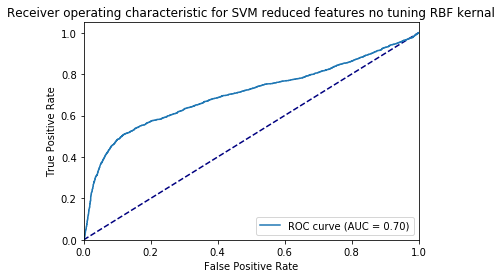

0.7040433457077317

In [81]:
#plot roc for svm
get_roc(clf_reduced, y_test, X_test_pca, 
        "SVM reduced features no tuning RBF kernal")

In [82]:
#confusion matrix
confusion(y_test,clf_reduced.predict(X_test_pca), "SVM reduced features no tuning RBF kernal")

Of 2020 Defaulters, the SVM reduced features no tuning RBF kernal identified 738


Predicted,0,1
Actual,,
0,6387,342
1,1282,738


In [83]:
print(classification_report(y_test, clf_reduced.predict(X_test_pca)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6729
           1       0.68      0.37      0.48      2020

    accuracy                           0.81      8749
   macro avg       0.76      0.66      0.68      8749
weighted avg       0.80      0.81      0.79      8749



As you can see, by reducing features through pca, Although the AUROC did not change much (0.001 increase), the number of correctly idendtified defaulters increased from 297 to 307, suggesting a better recall.

We will now try to find best parameters for SVM model

In [84]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1,10]
    gammas = [0.01, 0.1, 10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
svc_param_selection(X_train_pca, y_train,2)


{'C': 1, 'gamma': 0.1}

With 2 folds, it can be found that C = 10, and gamma = 0.01 will have the best svm model with RBF kernel

In [85]:
#train svm model with feature reduction and cost = 10, gamma = 0.01
clf_reduced_tuned = svm.SVC(kernel = 'rbf', probability = True, C= 10, gamma = 0.1)
clf_reduced_tuned.fit(X_train_pca, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Optimal Threshold: 0.16537143473786733


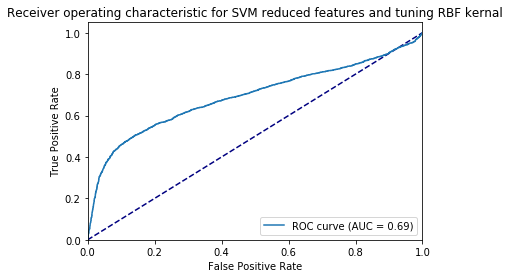

In [86]:
auroc = get_roc(clf_reduced_tuned, y_test, X_test_pca, 
        "SVM reduced features and tuning RBF kernal")

In [87]:
#confusion matrix
confusion(y_test,clf_reduced_tuned.predict(X_test_pca), "SVM reduced features and tuning RBF kernal")

Of 2020 Defaulters, the SVM reduced features and tuning RBF kernal identified 727


Predicted,0,1
Actual,,
0,6383,346
1,1293,727


In [88]:
print(classification_report(y_test, clf_reduced_tuned.predict(X_test_pca)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6729
           1       0.68      0.36      0.47      2020

    accuracy                           0.81      8749
   macro avg       0.75      0.65      0.68      8749
weighted avg       0.80      0.81      0.79      8749



From this, we can conclude that fitting SVM model with PCA-reduced features but no parameter tuning is most accurate based on Recall value

Thus, fitting an SVM with PCA-reduced features with default gamma = 1/13 and C = 1 with kernal = 'rbf' is the best model. However, this is only for rbf kernel.

In [89]:
evaluation.loc[4] = (["SVM" , 
                      classification_report(y_test, clf_reduced_tuned.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

ValueError: X.shape[1] = 44 should be equal to 13, the number of features at training time

### Neural Networks
We will now use the train and test sets as defined above and attempt to implement a neural network model on the data

#### Theory
A neural network is comprised of many layers of perceptrons that take in a vector as input and outputs a value. The outputs from one layer of perceptrons are passed into the next layer of perceptrons as input, until we reach the output layer. Each perceptron combines its input via an activation function. 

.


![image.png](https://www.researchgate.net/profile/Leslaw_Plonka/publication/260080460/figure/fig1/AS:340931325775876@1458295770470/A-simple-neural-network-diagram.png)


The network is at first randomly initialised with random weights on all its layers. Training samples are then passed into the network and predictions are made. The training error (difference between the actual value and the predicted value) is used to recalibrate the neural network by changing the weights. The change in weights is found via gradient descent, and  then backpropogated through the neural network to update all layers.


This process is repeated iteratively until the model converges (i.e. it cannot be improved further).

#### Training
Here we create an instance of our model, with 5 layers of 26 neurons each, identical to that of our training data. 

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(26,26,26,26,26), activation = "logistic")

In [ ]:
mlp.fit(X_train,y_train)

In [ ]:
predictions = mlp.predict(X_test)

In [ ]:
confusion(y_test,predictions,"Neural Network (5x26)")

In [ ]:
auroc = get_roc(mlp, y_test, X_test, "Neural Network (5x26)")

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
evaluation.loc[5] = (["Neural Network" , 
                      classification_report(y_test, mlp.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

evaluation

### Deep Learning

#### Theory



In [ ]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=26, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)


In [ ]:
# evaluate the keras model
#recall, accuracy = model.evaluate(df1, target)
#print('Accuracy: %.2f' % (accuracy*100))
#print('Recall: %.2f' % (recall*100))

predictions = list(model.predict(X_test).ravel() > 0.5)
print(classification_report(y_test,predictions))